In [1]:
%matplotlib notebook

# Introduction
We will perform curve tracing of a Transistor.  
In the experiment, we will plot current $I_{b}$ verses $V_{ce}$ for a given $I_{b}$.

# Connection
![Breadboard](../extra/img/fritzing/Transistor Curve Tracing_bb.png)
![Schematic](../extra/img/fritzing/Transistor Curve Tracing_schem.png)

# Code

<IPython.core.display.Javascript object>


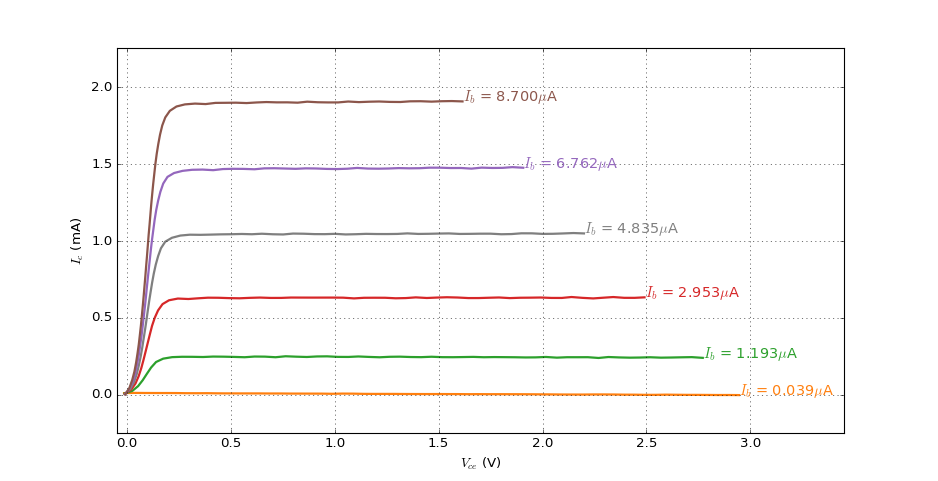

In [16]:
import box0
import numpy as np
import matplotlib.pyplot as plt

# some constant
RESISTANCE_BASE = 100e3
RESISTANCE_COLLECTOR = 330

# allocate the appropriate resources
dev = box0.usb.open_supported()
ain0 = dev.ain(0)
aout0 = dev.aout(0)

# prepare the resources

ain0.snapshot_prepare()
ain0.chan_seq_set([0, 1, 2, 3])
ain0.bitsize_speed_set(12, 100000) # 100KSPS

aout0.snapshot_prepare()
aout0.chan_seq_set([0, 1])
aout0.bitsize_speed_set(12, 100000) # 100KSPS

def set_voltage(ch0, ch1):
    """Set voltage on AOUT0 pin"""
    global aout0

    # try to stop aout0 (from previous start)
    try: aout0.snapshot_stop()
    except: pass

    data = np.array([ch0, ch1])
    aout0.snapshot_start(data)

def get_voltage():
    """Get voltage on AIN0 pin"""
    global ain0

    data = np.empty(1000)
    ain0.snapshot_start(data)

    ch0 = np.mean(data[0::4])
    ch1 = np.mean(data[1::4])
    ch2 = np.mean(data[2::4])
    ch3 = np.mean(data[3::4])

    return ch0, ch1, ch2, ch3

def pretty_title_from_base_current(value):
    """return a pretty title using base input current"""
    prefix = ""
    if value < 1e-3:
        prefix = "$\mu$"
        value *= 1e6
    elif base_current < 1:
        prefix = "m"
        value *= 1e3
    return r'$I_{b}$ = %.3f%sA' % (value, prefix)

colors = ['#ff7f0e', '#2ca02c', '#d62728', '#7f7f7f', '#9467bd', '#8c564b']


for aout0_ch0 in [0.4, 0.7, 0.9, 1.1, 1.3, 1.5]:
    arr_current_base = []
    arr_current_collector = []
    arr_voltage_collector_emitter = []

    for aout0_ch1 in np.arange(0, 3, 0.05):
        # set the values
        set_voltage(aout0_ch0, aout0_ch1)

        # get the values
        ain0_ch0, ain0_ch1, ain0_ch2, ain0_ch3 = get_voltage()

        # do the calculation
        current_base = (ain0_ch0 - ain0_ch2) / RESISTANCE_BASE
        curent_collector = (ain0_ch1 - ain0_ch3) / RESISTANCE_COLLECTOR
        voltage_collector_emitter = ain0_ch3

        # append to list
        arr_current_base.append(current_base)
        arr_current_collector.append(curent_collector)
        arr_voltage_collector_emitter.append(voltage_collector_emitter)

    # plot it
    title = pretty_title_from_base_current(np.mean(arr_current_base))
    color = colors.pop(0)
    arr_current_collector = [x * 1e3 for x in arr_current_collector] # to mA
    line = plt.plot(arr_voltage_collector_emitter, arr_current_collector, label=title, color=color, linewidth=2)
    plt.text(arr_voltage_collector_emitter[-1], arr_current_collector[-1], title, fontsize=13, color=color)

# try to stop aout0 (from previous start)
try: aout0.snapshot_stop()
except: pass

# close the resources
ain0.close()
aout0.close()
dev.close()

#plt.legend()
plt.grid(True)
plt.xlabel(r"$V_{ce}$ (V)")
plt.ylabel(r"$I_{c}$ (mA)")
plt.show()